# Chapter 7 - Ensemble Learning

# Exercise 1 - Voting Classifiers

* This notebook is created to execute and experiment with the exercise from Chapter 7 of "Hands-on ML" book. 
* The exercise details are as follows, 
    * Load the MNIST dataset (introduced in Chapter 3), and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing).
    * Then train various classifiers, such as a random forest classifier, an extra-trees classifier, and an SVM classifier. 
    * Next, try to combine them into an ensemble that outperforms each individual classifier on the validation set, using soft or hard voting. 
    * Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?

## Plan
* After experimenting in previous we realized that the model with Augmented dataset performs a lot better than the default regular dataset. So thats what I want to use for this exercise. 
* The plan is as follows,
    * Split the data into training set, validation set and test set. 
    * Augment the entire dataset (instead of just the training set as before) and save it as CSV for future use.     
    * Train the following classifiers, (we've trained them in previous notebooks)
        * Logistic Regression
        * SVC
        * Random Foreset
        * KNN
        * Extra Trees Classifier
        * Gradient Boosting Classifier
    * We'll just try `Hard Voting` for now since for `Soft Voting` we need probabilities and calculating those for `SVM` can be time consuming. 
    * For the first version I think I'll train them using default params and then may be try training them using best params I got in previous notebooks. 
    * Compare the performance against individual classifiers and best classifier in previous notebook



## Import Libraries

In [2]:
from sklearn.preprocessing import Binarizer, OneHotEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict,GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from pathlib import Path
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier,StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


from sklearn.metrics import ConfusionMatrixDisplay, f1_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.dummy import DummyClassifier


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import joblib
import json
import gdown
import os
import sys
import tqdm
import time
import warnings
from huggingface_hub import login, HfApi,list_repo_files, hf_hub_download
import os
import sys
import dotenv
from pathlib import Path
import tqdm

## Setup Hugging Face

In [3]:
dotenv.load_dotenv()
HF_TOKEN = os.getenv("HF_TOKEN")

## login huggingface user
if HF_TOKEN is None:
    print("Please set the HF_TOKEN environment variable. This is you hugging face token")
else:
    print("Logging in...")
    login(HF_TOKEN)
    
api = HfApi()
user = api.whoami()
user_name = user['name']
print(f"Logged in as {user_name}")

Logging in...


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Logged in as gaurangdave


## Download Models & Data

In [4]:
# # Get the directory of the notebook
## this is root directory of jupyterlab
notebook_dir = os.getcwd()

# from api.utils.common import augment_dataset,download_data_from_gdrive
project_root = os.path.abspath(os.path.join(notebook_dir , "mnist_digits_recognition"))  
model_root = os.path.join(project_root, "models")
model_dir = project_root + '/models/ensemble/'
data_root = os.path.join(project_root, "data")

## hugging face repo id
model_name = "mnist_digits_recognition"
repo_id = f"{user_name}/{model_name}"


In [4]:
all_models = api.list_repo_files(repo_id, repo_type="model")

print(f"Models in {repo_id}:")
for model in all_models:
    ## download to tmp folder
    file_path = hf_hub_download(repo_id=repo_id, filename=model, token=HF_TOKEN, local_dir=model_root, repo_type="model")
    ## move to model folder
    os.rename(file_path, os.path.join(model_root, model))
    print(f"Downloaded {model} to {file_path}")

print(f"✅ All files downloaded to {model_root}")

Models in gaurangdave/mnist_digits_recognition:
Downloaded .gitattributes to /home/gaurangdave/jupyterlab/mnist_digits_recognition/models/.gitattributes
Downloaded default_logistic_regression_probabilites.csv to /home/gaurangdave/jupyterlab/mnist_digits_recognition/models/default_logistic_regression_probabilites.csv
Downloaded ensemble/extra_trees_model.pkl to /home/gaurangdave/jupyterlab/mnist_digits_recognition/models/ensemble/extra_trees_model.pkl
Downloaded ensemble/gradient_boosting_model.pkl to /home/gaurangdave/jupyterlab/mnist_digits_recognition/models/ensemble/gradient_boosting_model.pkl
Downloaded ensemble/knn_model.pkl to /home/gaurangdave/jupyterlab/mnist_digits_recognition/models/ensemble/knn_model.pkl


logistic_regression_model.pkl:   0%|          | 0.00/109k [00:00<?, ?B/s]

Downloaded ensemble/logistic_regression_model.pkl to /home/gaurangdave/jupyterlab/mnist_digits_recognition/models/ensemble/logistic_regression_model.pkl
Downloaded ensemble/random_forest_model.pkl to /home/gaurangdave/jupyterlab/mnist_digits_recognition/models/ensemble/random_forest_model.pkl
Downloaded ensemble/soft_voting_classifier_model.pkl to /home/gaurangdave/jupyterlab/mnist_digits_recognition/models/ensemble/soft_voting_classifier_model.pkl
Downloaded ensemble/svc_model.pkl to /home/gaurangdave/jupyterlab/mnist_digits_recognition/models/ensemble/svc_model.pkl
Downloaded ensemble/tuned_knn_model.pkl to /home/gaurangdave/jupyterlab/mnist_digits_recognition/models/ensemble/tuned_knn_model.pkl
Downloaded ensemble/tuned_logistic_regression_model.pkl to /home/gaurangdave/jupyterlab/mnist_digits_recognition/models/ensemble/tuned_logistic_regression_model.pkl
Downloaded ensemble/tuned_logistic_regression_v0.pkl to /home/gaurangdave/jupyterlab/mnist_digits_recognition/models/ensemble/tu

In [5]:
all_data = api.list_repo_files(repo_id, repo_type="dataset")
    
print(f"Datasets in {repo_id}:")
for dataset in all_data:
    ## download to tmp folder
    file_path = hf_hub_download(repo_id=repo_id, filename=dataset, token=HF_TOKEN, local_dir=data_root, repo_type="dataset")
    ## move to model folder
    os.rename(file_path, os.path.join(data_root, dataset))
    print(f"Downloaded {dataset} to {file_path}")

print(f"✅ All files downloaded to {model_root}")

    

Datasets in gaurangdave/mnist_digits_recognition:
Downloaded .gitattributes to /home/gaurangdave/jupyterlab/mnist_digits_recognition/data/.gitattributes
Downloaded augmented_ensemle_learning_mnist_data.csv to /home/gaurangdave/jupyterlab/mnist_digits_recognition/data/augmented_ensemle_learning_mnist_data.csv
Downloaded augmented_mnist_data.csv to /home/gaurangdave/jupyterlab/mnist_digits_recognition/data/augmented_mnist_data.csv
Downloaded augmented_train_X.csv to /home/gaurangdave/jupyterlab/mnist_digits_recognition/data/augmented_train_X.csv
Downloaded augmented_train_Y.csv to /home/gaurangdave/jupyterlab/mnist_digits_recognition/data/augmented_train_Y.csv
Downloaded mnist_test_set.csv to /home/gaurangdave/jupyterlab/mnist_digits_recognition/data/mnist_test_set.csv
Downloaded mnist_train_set.csv to /home/gaurangdave/jupyterlab/mnist_digits_recognition/data/mnist_train_set.csv
Downloaded raw_mnist_data.csv to /home/gaurangdave/jupyterlab/mnist_digits_recognition/data/raw_mnist_data.cs

## Import Custom Scripts

In [5]:
def shift_image(image, direction):
    """
    Shift an MNIST image in a given direction.

    Args:
        image (np.ndarray): 1D array of 784 pixels (28x28 image).
        direction (str): One of 'up', 'down', 'left', 'right'.

    Returns:
        np.ndarray: Shifted 1D image (flattened).
    """
    # Reshape the flat image to 28x28
    image_2d = image.reshape(28, 28)
    # Create an empty 28x28 array filled with zeros
    shifted = np.zeros_like(image_2d)

    # Perform the shift based on the direction
    if direction == "up":
        shifted[:-1, :] = image_2d[1:, :]  # Shift rows up
    elif direction == "down":
        shifted[1:, :] = image_2d[:-1, :]  # Shift rows down
    elif direction == "left":
        shifted[:, :-1] = image_2d[:, 1:]  # Shift columns left
    elif direction == "right":
        shifted[:, 1:] = image_2d[:, :-1]  # Shift columns right

    # Flatten the shifted image back to 1D
    return shifted.flatten()


def augment_dataset(X, y):
    """
    Augment the MNIST dataset by creating shifted versions of each image.

    Args:
        X (pd.DataFrame): Dataset with features (flattened MNIST images).
        y (pd.Series): Labels for the images.

    Returns:
        pd.DataFrame, pd.Series: Augmented dataset (features and labels).
    """
    augmented_X = []
    augmented_y = []

    directions = ["up", "down", "left", "right"]
    total_iterations = len(X)

    # Iterate through each image and label
    with tqdm.tqdm(total=total_iterations, desc="Augmenting Data") as pbar:
        for image, label in zip(X.values, y.values):
            # Append the original image
            augmented_X.append(image)
            augmented_y.append(label)

            # Create shifted images for all four directions
            for direction in directions:
                shifted_image = shift_image(image, direction)
                augmented_X.append(shifted_image)
                augmented_y.append(label)  # Same label for shifted image
            pbar.update(1)

    print("converting lists to DataFrame and Series")
    # Convert lists to DataFrame and Series
    augmented_X = pd.DataFrame(augmented_X, columns=X.columns)
    augmented_y = pd.Series(augmented_y)

    return augmented_X, augmented_y

## Read Data

In [6]:
raw_data = pd.read_csv(data_root + '/raw_mnist_data.csv')

In [7]:
raw_data.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [8]:
raw_data.shape

(70000, 785)

## Train, Validation & Test Split

In [9]:
## split the data into variables and target
X = raw_data.drop(columns=['class'])
y = raw_data['class']


In [10]:
## split train, validate and test data splits
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train.shape, X_val.shape, X_test.shape

((44800, 784), (11200, 784), (14000, 784))

## Augment Data

In [12]:
augmented_X, augmented_y = augment_dataset(X_train, y_train)

Augmenting Data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44800/44800 [00:01<00:00, 25133.70it/s]


converting lists to DataFrame and Series


In [13]:
augmented_X.shape, augmented_y.shape

((224000, 784), (224000,))

In [14]:
## save the augmented data
augmented_data = pd.concat([augmented_X, augmented_y], axis=1)
augmented_data.to_csv(data_root + '/augmented_ensemle_learning_mnist_data.csv', index=False)

In [11]:
## read the augmented data
augmented_data = pd.read_csv(data_root + '/augmented_ensemle_learning_mnist_data.csv')

## split the data into variables and target
augmented_X = augmented_data.drop(columns=['0'])
augmented_y = augmented_data['0']

## Train Models using default params

### Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

# initialize LogisticRegression
logistic_regression = LogisticRegression(n_jobs=-1, random_state=42, max_iter=10000)

# create pipeline
logistic_regression_pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("logistic_regression", logistic_regression)
])

In [17]:
## fit the model
start_time = time.time()
logistic_regression_pipeline.fit(augmented_X, augmented_y)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f}s")

Training time: 288.37s


In [18]:
## save the model
saved_location = joblib.dump(logistic_regression_pipeline, model_dir + 'logistic_regression_model.pkl')

### SVC

In [19]:
svc_base = SVC(probability=True, random_state=42)  # Enable probability for AUC

# create pipeline
default_svc_pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("svc", svc_base)
])

In [20]:
start_time = time.time()
default_svc_pipeline.fit(augmented_X, augmented_y)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f}s")

Training time: 12811.00s


In [21]:
## save the model
saved_location = joblib.dump(default_svc_pipeline, model_dir + 'svc_model.pkl')

### Random Forest

In [22]:
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

# Create a pipeline
rfc_pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("randomforest", rfc)
])

In [23]:
start_time = time.time()
rfc_pipeline.fit(augmented_X, augmented_y)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f}s")

Training time: 21.82s


In [24]:
## save the model
saved_location = joblib.dump(rfc_pipeline, model_dir + 'random_forest_model.pkl')

### KNN

In [25]:
knn = KNeighborsClassifier( n_jobs=-1)

# Create a pipeline
knn_pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("knn", knn)
])

In [26]:
start_time = time.time()
knn_pipeline.fit(augmented_X, augmented_y)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f}s")

Training time: 2.38s


In [27]:
## save the model
saved_location = joblib.dump(knn_pipeline, model_dir + 'knn_model.pkl')

### Extra Trees Classifier

In [28]:
extra_trees = ExtraTreesClassifier(n_jobs=-1, random_state=42)

# Create a pipeline
extra_trees_pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("extra_trees", extra_trees)
])

start_time = time.time()
extra_trees_pipeline.fit(augmented_X, augmented_y)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f}s")

Training time: 28.31s


In [29]:
## save the model
saved_location = joblib.dump(extra_trees_pipeline, model_dir + 'extra_trees_model.pkl')

### Gradient Boosting Classifier

In [30]:
## Gradient Boosting Classifier
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Create a pipeline
gb_pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("gb", gb)
])

start_time = time.time()
gb_pipeline.fit(augmented_X, augmented_y)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f}s")

Training time: 6551.28s


In [31]:
## save the model
saved_location = joblib.dump(gb_pipeline, model_dir + 'gradient_boosting_model.pkl')

### Ensemble with Voting Classifier (Hard Voting)


In [ ]:
## read all saved details in case the notebook is restarted
model_dir = project_root + '/models/ensemble/'
data_dir = project_root + '/data/'

## read the augmented data from augmented_ensemle_learning_mnist_data.csv
augmented_data = pd.read_csv(data_dir + 'augmented_ensemle_learning_mnist_data.csv')

## split the data into variables and target
augmented_X = augmented_data.drop(columns=['0'])
augmented_y = augmented_data['0']


## read estimators from saved models
logistic_regression = joblib.load(model_dir + 'logistic_regression_model.pkl')
svc = joblib.load(model_dir + 'svc_model.pkl')
random_forest = joblib.load(model_dir + 'random_forest_model.pkl')
knn = joblib.load(model_dir + 'knn_model.pkl')
extra_trees = joblib.load(model_dir + 'extra_trees_model.pkl')
gradient_boosting = joblib.load(model_dir + 'gradient_boosting_model.pkl')  

In [33]:
voting_clf = VotingClassifier(
    estimators=[
        ("LogReg", logistic_regression),
        ("SVC", svc),
        ("RF", random_forest),
        ("KNN", knn),
        ("ExtraTrees", extra_trees),
        ("GB", gradient_boosting)
    ],
    voting="hard"  # Use "soft" if all models support probability predictions
)

* fit (Optional but Necessary for scikit-learn VotingClassifier): While the models are pre-trained, the VotingClassifier still needs to be "fitted" to understand the labels (classes). 
* We can fit it with a small dummy dataset, or an empty dataset, or even just pass an empty array for X and y


In [34]:
start_time = time.time()
voting_clf.fit(X_train, y_train)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f}s")

Training time: 2108.68s


In [35]:
## save the model
saved_location = joblib.dump(voting_clf, model_dir + 'voting_classifier_model.pkl')

### Prediction

In [36]:
## predict on the validation set
y_val_pred = voting_clf.predict(X_val)

In [37]:
# Compute metrics
accuracy = accuracy_score(y_val, y_val_pred)
weighted_f1 = f1_score(y_val, y_val_pred, average='weighted')
# Compute per-class F1 scores
per_class_f1_scores = f1_score(y_val, y_val_pred, average=None)
per_class_f1_dict = {f"Class_{i}": score for i, score in enumerate(per_class_f1_scores)}

In [38]:
## print the metrics
print(f"Accuracy: {accuracy}")
print(f"Weighted F1: {weighted_f1}")
print("Per-class F1 scores: ", per_class_f1_dict)


Accuracy: 0.9721428571428572
Weighted F1: 0.9720921798301937
Per-class F1 scores:  {'Class_0': 0.9764192139737992, 'Class_1': 0.9886851346078814, 'Class_2': 0.9684400360685302, 'Class_3': 0.9691438504997827, 'Class_4': 0.9760506100316313, 'Class_5': 0.9781659388646288, 'Class_6': 0.9752747252747253, 'Class_7': 0.9704090513489991, 'Class_8': 0.9644341801385681, 'Class_9': 0.9511153298528714}


### Ensemble with Voting Classifier (Soft Voting)


Observations:
* So the `Accuracy` and `F1 Scores`

In [39]:
soft_voting_clf = VotingClassifier(
    estimators=[
        ("LogReg", logistic_regression),
        ("SVC", svc),
        ("RF", random_forest),
        ("KNN", knn),
        ("ExtraTrees", extra_trees),
        ("GB", gradient_boosting)
    ],
    voting="soft"  # Use "soft" if all models support probability predictions
)

In [40]:
start_time = time.time()
soft_voting_clf.fit(X_train, y_train)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f}s")

Training time: 2094.59s


In [41]:
## save the model
saved_location = joblib.dump(soft_voting_clf, model_dir + 'soft_voting_classifier_model.pkl')

In [42]:
## predict on the validation set
y_val_pred = soft_voting_clf.predict(X_val)

In [43]:
# Compute metrics
accuracy = accuracy_score(y_val, y_val_pred)
weighted_f1 = f1_score(y_val, y_val_pred, average='weighted')
# Compute per-class F1 scores
per_class_f1_scores = f1_score(y_val, y_val_pred, average=None)
per_class_f1_dict = {f"Class_{i}": score for i, score in enumerate(per_class_f1_scores)}

In [44]:
## print the metrics
print(f"Accuracy: {accuracy}")
print(f"Weighted F1: {weighted_f1}")
print("Per-class F1 scores: ", per_class_f1_dict)

Accuracy: 0.9729464285714285
Weighted F1: 0.9729077740577333
Per-class F1 scores:  {'Class_0': 0.9811155028546333, 'Class_1': 0.9852140077821012, 'Class_2': 0.9712984054669704, 'Class_3': 0.9698558322411533, 'Class_4': 0.9759637188208616, 'Class_5': 0.9744084983099952, 'Class_6': 0.9744292237442922, 'Class_7': 0.9722463139635733, 'Class_8': 0.9677716390423573, 'Class_9': 0.9543529411764706}


Observations:
* So voting classifier significantly outperforms most of the individual default estimators.
* The closest model was default `SVC`, but its still not better then tuned `SVM` that we ended up using in prod, which had accuract and F1 score of .9897. 
* Next step would be to tune all the models and create an ensemble using the best model.
    * For that we'll tune all the models using GridSearch except SVC, since we already have best params for that and training is time consuming. 

## Hyper-param Tuning

* In order to save time, on training models and focusing on learning, we are going to train the models using the best params that we found in previous work sheet. 
* Even though the best params were found on non-augmented data, they are likely to perform well on augmented data too.
* We can add hyper-param tuning as future enhancements

### Logistic Regression

In [45]:
## Below are the hyperparameters for the models
#  Preprocessing: `normalize`
#  Solver : `newton-cg`
#  C : `0.1`
#  Penalty : `l2`
# initialize LogisticRegression
logistic_regression = LogisticRegression(solver="newton-cg", C=0.1, penalty="l2", n_jobs=-1, random_state=42, max_iter=10000)

# create pipeline
tuned_logistic_regression_pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("logisticregression", logistic_regression)
])

In [46]:
## start timer

start = time.time()
tuned_logistic_regression_pipeline.fit(augmented_X, augmented_y)
end = time.time()
print(f"Training time: {end - start:.2f}s")

Training time: 131.65s


In [47]:
## save the model
saved_location = joblib.dump(tuned_logistic_regression_pipeline, model_dir + 'tuned_logistic_regression_model.pkl')

In [48]:
## predict on the validation set
y_val_pred = tuned_logistic_regression_pipeline.predict(X_val)
# Compute metrics
accuracy = accuracy_score(y_val, y_val_pred)
weighted_f1 = f1_score(y_val, y_val_pred, average='weighted')
# Compute per-class F1 scores
per_class_f1_scores = f1_score(y_val, y_val_pred, average=None)
per_class_f1_dict = {f"Class_{i}": score for i, score in enumerate(per_class_f1_scores)}
## print the metrics
print(f"Accuracy: {accuracy}")
print(f"Weighted F1: {weighted_f1}")
print("Per-class F1 scores: ", per_class_f1_dict)


Accuracy: 0.9197321428571429
Weighted F1: 0.9194301831211195
Per-class F1 scores:  {'Class_0': 0.9606986899563319, 'Class_1': 0.9517660463349791, 'Class_2': 0.9100185528756958, 'Class_3': 0.9082853345148427, 'Class_4': 0.9278996865203761, 'Class_5': 0.8815212091662603, 'Class_6': 0.9409610983981693, 'Class_7': 0.9341527655838455, 'Class_8': 0.872794800371402, 'Class_9': 0.8969024503005085}


### SVM

In [49]:
## training svc on the augmented data using best hyperparameters
svc = SVC(C=10, gamma="scale", kernel="rbf", random_state=42, probability=True)

# create pipeline

print("Creating pipeline...")
svc_pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("svc", svc)
], verbose=True)

Creating pipeline...


In [50]:
start_time = time.time()
svc_pipeline.fit(augmented_X, augmented_y.values.ravel())
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f}s")


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   1.1s
[Pipeline] .............. (step 2 of 2) Processing svc, total=250.8min
Training time: 15048.24s


In [51]:
## save the model
saved_location = joblib.dump(svc_pipeline, model_dir + 'tuned_svc_model.pkl')

In [52]:
## predict on the validation set
y_val_pred = svc_pipeline.predict(X_val)
# Compute metrics
accuracy = accuracy_score(y_val, y_val_pred)
weighted_f1 = f1_score(y_val, y_val_pred, average='weighted')
# Compute per-class F1 scores
per_class_f1_scores = f1_score(y_val, y_val_pred, average=None)
per_class_f1_dict = {f"Class_{i}": score for i, score in enumerate(per_class_f1_scores)}
## print the metrics
print(f"Accuracy: {accuracy}")
print(f"Weighted F1: {weighted_f1}")
print("Per-class F1 scores: ", per_class_f1_dict)


Accuracy: 0.98875
Weighted F1: 0.9887464218354948
Per-class F1 scores:  {'Class_0': 0.9911347517730497, 'Class_1': 0.9949159170903402, 'Class_2': 0.9882459312839059, 'Class_3': 0.9855579868708971, 'Class_4': 0.9873303167420815, 'Class_5': 0.9889049686444766, 'Class_6': 0.9876543209876543, 'Class_7': 0.9886759581881533, 'Class_8': 0.9876316994961063, 'Class_9': 0.9864549276039234}


### Random Forest

In [53]:
## below are the best hyperparameters for the random forest classifier
## Best Parameters: {'preprocessing__kw_args': {'method': 'normalize'}, 'randomforest__max_depth': None, 'randomforest__min_samples_leaf': 1, 'randomforest__min_samples_split': 2, 'randomforest__n_estimators': 200}

rfc = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42, n_jobs=-1)

tuned_rfc_pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("randomforest", rfc)
])

start = time.time()
tuned_rfc_pipeline.fit(augmented_X, augmented_y)
end = time.time()
print(f"Training time: {end - start:.2f}s")

## save the model
saved_location = joblib.dump(tuned_rfc_pipeline, model_dir + 'tuned_random_forest_model.pkl')

## predict on the validation set
y_val_pred = tuned_rfc_pipeline.predict(X_val)
# Compute metrics
accuracy = accuracy_score(y_val, y_val_pred)
weighted_f1 = f1_score(y_val, y_val_pred, average='weighted')
# Compute per-class F1 scores
per_class_f1_scores = f1_score(y_val, y_val_pred, average=None)
per_class_f1_dict = {f"Class_{i}": score for i, score in enumerate(per_class_f1_scores)}
## print the metrics
print(f"Accuracy: {accuracy}")
print(f"Weighted F1: {weighted_f1}")
print("Per-class F1 scores: ", per_class_f1_dict)


Training time: 35.12s
Accuracy: 0.9798214285714286
Weighted F1: 0.9798328131009487
Per-class F1 scores:  {'Class_0': 0.9850088183421517, 'Class_1': 0.9901768172888016, 'Class_2': 0.9805517865219358, 'Class_3': 0.9781659388646288, 'Class_4': 0.9808743169398907, 'Class_5': 0.9845111326234269, 'Class_6': 0.9790145985401459, 'Class_7': 0.981230903535574, 'Class_8': 0.9743824336688015, 'Class_9': 0.9624129930394432}


### KNN

In [20]:
## Best KNN Params are 
## {'knn__algorithm': 'auto', 'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'distance'}

knn = KNeighborsClassifier(algorithm='auto', n_neighbors=5, p=2, weights='distance', n_jobs=-1)

tuned_knn_pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("knn", knn)
])

start = time.time()
tuned_knn_pipeline.fit(augmented_X, augmented_y)
end = time.time()

print(f"Training time: {end - start:.2f}s")
## save the model
saved_location = joblib.dump(tuned_knn_pipeline, model_dir + 'tuned_knn_model.pkl')

## predict on the validation set
y_val_pred = tuned_knn_pipeline.predict(X_val)
# Compute metrics
accuracy = accuracy_score(y_val, y_val_pred)
weighted_f1 = f1_score(y_val, y_val_pred, average='weighted')
# Compute per-class F1 scores
per_class_f1_scores = f1_score(y_val, y_val_pred, average=None)
per_class_f1_dict = {f"Class_{i}": score for i, score in enumerate(per_class_f1_scores)}
## print the metrics
print(f"Accuracy: {accuracy}")
print(f"Weighted F1: {weighted_f1}")
print("Per-class F1 scores: ", per_class_f1_dict)

Training time: 3.10s
Accuracy: 0.97875
Weighted F1: 0.9787129524087814
Per-class F1 scores:  {'Class_0': 0.9846153846153847, 'Class_1': 0.9841637697952877, 'Class_2': 0.9803383630544125, 'Class_3': 0.9812472743131269, 'Class_4': 0.9803921568627451, 'Class_5': 0.9806949806949807, 'Class_6': 0.9809264305177112, 'Class_7': 0.9813449023861172, 'Class_8': 0.9661971830985916, 'Class_9': 0.9656453110492108}


### Extra Trees Classifier

* We don't have best params for `Extra Trees Classifier` so we'll need to run grid search for this. 
* We'll try to see if we can fit and find the best params quickly else we'll skip this model

In [14]:
param_grid = {
    "extra_trees__n_estimators": [100, 200, 300],
    "extra_trees__max_depth": [None, 10, 20, 30],
    "extra_trees__min_samples_split": [2, 5, 10],
    "extra_trees__min_samples_leaf": [1, 2, 4],
    "extra_trees__bootstrap": [True, False]
}

extra_trees = ExtraTreesClassifier(n_jobs=-1, random_state=42)

# Create a pipeline
extra_trees_pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("extra_trees", extra_trees)
])

## important thing to notice here, setting n_jobs=-1 in RandomizedSearchCV will cause the notebook to crash.
extra_trees_grid_search = GridSearchCV(extra_trees_pipeline, param_grid, cv=3, verbose=1 , n_jobs=4)


start = time.time()
extra_trees_grid_search.fit(augmented_X, augmented_y)
end = time.time()
print(f"Training time: {end - start:.2f}s")



Fitting 3 folds for each of 216 candidates, totalling 648 fits
Training time: 13793.25s


* Just a interesting note, all the time invested in setting up jupyter server on a gaming machine and moving the training there, paid off. The above grid search took ~4 hours of training, but previously it didn't finish training for 12+ hours

In [15]:
## print the best parameters
print("Best Parameters: ", extra_trees_grid_search.best_params_)
## print the best score
print("Best Score: ", extra_trees_grid_search.best_score_)

Best Parameters:  {'extra_trees__bootstrap': False, 'extra_trees__max_depth': None, 'extra_trees__min_samples_leaf': 1, 'extra_trees__min_samples_split': 2, 'extra_trees__n_estimators': 300}
Best Score:  0.9723169649422987


In [16]:
## save the model
saved_location = joblib.dump(extra_trees_grid_search.best_estimator_, model_dir + 'tuned_extra_trees_model.pkl')

In [23]:
Path(model_dir + 'tuned_extra_trees_model.pkl').relative_to(model_root)

PosixPath('ensemble/tuned_extra_trees_model.pkl')

In [25]:
## upload the model to hugging face
path_or_fileobj = Path(model_dir + 'tuned_extra_trees_model.pkl')
path_in_repo = path_or_fileobj.relative_to(model_root)
api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="model")

tuned_extra_trees_model.pkl:   0%|          | 0.00/3.05G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/gaurangdave/mnist_digits_recognition/commit/7c8a68208b45637713d7151c7a03f704b02137b7', commit_message='Upload ensemble/tuned_extra_trees_model.pkl with huggingface_hub', commit_description='', oid='7c8a68208b45637713d7151c7a03f704b02137b7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gaurangdave/mnist_digits_recognition', endpoint='https://huggingface.co', repo_type='model', repo_id='gaurangdave/mnist_digits_recognition'), pr_revision=None, pr_num=None)

In [26]:
## predict on the validation set
y_val_pred = extra_trees_grid_search.best_estimator_.predict(X_val)
# Compute metrics
accuracy = accuracy_score(y_val, y_val_pred)
weighted_f1 = f1_score(y_val, y_val_pred, average='weighted')
# Compute per-class F1 scores
per_class_f1_scores = f1_score(y_val, y_val_pred, average=None)
per_class_f1_dict = {f"Class_{i}": score for i, score in enumerate(per_class_f1_scores)}
## print the metrics
print(f"Accuracy: {accuracy}")
print(f"Weighted F1: {weighted_f1}")
print("Per-class F1 scores: ", per_class_f1_dict)

Accuracy: 0.9810714285714286
Weighted F1: 0.9810816413993403
Per-class F1 scores:  {'Class_0': 0.9876434245366285, 'Class_1': 0.9913657770800628, 'Class_2': 0.9791099000908265, 'Class_3': 0.9773123909249564, 'Class_4': 0.9836214740673339, 'Class_5': 0.9845261121856866, 'Class_6': 0.98359161349134, 'Class_7': 0.9825174825174825, 'Class_8': 0.9739368998628258, 'Class_9': 0.9652294853963839}


### Gradient Boosting Classifier

In [12]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 1],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 0.9, 1.0],
    "max_features": [None, "sqrt", "log2"]
}

gb_clf = GradientBoostingClassifier(random_state=42)

# Create a pipeline
# gb_pipeline = Pipeline([
#     ("scaler", MinMaxScaler()),
#     ("gb", gb_clf)
# ])

gb_grid_search = RandomizedSearchCV(gb_clf, param_grid, cv=3, verbose=1,  n_jobs=10, n_iter=20,random_state=42)

start = time.time()
gb_grid_search.fit(augmented_X, augmented_y)
end = time.time()
print(f"Training time: {end - start:.2f}s")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training time: 25558.94s


In [ ]:
## print the best parameters
print("Best Parameters: ", gb_grid_search.best_params_)
## print the best score
print("Best Score: ", gb_grid_search.best_score_)


Best Parameters:  {'subsample': 1.0, 'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 7, 'learning_rate': 0.1}
Best Score:  0.9789017826243046


In [14]:
## save the model
saved_location = joblib.dump(gb_grid_search.best_estimator_, model_dir + 'tuned_gradient_boosting_model.pkl')

In [15]:
## upload the model to hugging face
path_or_fileobj = Path(model_dir + 'tuned_gradient_boosting_model.pkl')
path_in_repo = path_or_fileobj.relative_to(model_root)
api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="model")

tuned_gradient_boosting_model.pkl:   0%|          | 0.00/66.6M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/gaurangdave/mnist_digits_recognition/commit/b7cdd390f3d2ae7719a6e803250d3758b67927c9', commit_message='Upload ensemble/tuned_gradient_boosting_model.pkl with huggingface_hub', commit_description='', oid='b7cdd390f3d2ae7719a6e803250d3758b67927c9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gaurangdave/mnist_digits_recognition', endpoint='https://huggingface.co', repo_type='model', repo_id='gaurangdave/mnist_digits_recognition'), pr_revision=None, pr_num=None)

In [16]:
## predict on the validation set
y_val_pred = gb_grid_search.best_estimator_.predict(X_val)
# Compute metrics
accuracy = accuracy_score(y_val, y_val_pred)
weighted_f1 = f1_score(y_val, y_val_pred, average='weighted')
# Compute per-class F1 scores
per_class_f1_scores = f1_score(y_val, y_val_pred, average=None)
per_class_f1_dict = {f"Class_{i}": score for i, score in enumerate(per_class_f1_scores)}
## print the metrics
print(f"Accuracy: {accuracy}")
print(f"Weighted F1: {weighted_f1}")
print("Per-class F1 scores: ", per_class_f1_dict)

Accuracy: 0.9860714285714286
Weighted F1: 0.9860734485464957
Per-class F1 scores:  {'Class_0': 0.9876325088339223, 'Class_1': 0.9956744003145891, 'Class_2': 0.9823449524671797, 'Class_3': 0.9846827133479212, 'Class_4': 0.9855334538878843, 'Class_5': 0.9893822393822393, 'Class_6': 0.9835164835164835, 'Class_7': 0.9851657940663177, 'Class_8': 0.9836065573770492, 'Class_9': 0.9818012132524498}


### Load Models

* Lets load all models from the `pkl` files to validate individually and then create an ensemble

In [50]:
## read estimators from saved models
logistic_regression = joblib.load(model_dir + 'tuned_logistic_regression_model.pkl')
svc = joblib.load(model_dir + 'tuned_svc_model.pkl')
random_forest = joblib.load(model_dir + 'tuned_random_forest_model.pkl')
knn = joblib.load(model_dir + 'tuned_knn_model.pkl')
extra_trees = joblib.load(model_dir + 'tuned_extra_trees_model.pkl')
gradient_boosting = joblib.load(model_dir + 'tuned_gradient_boosting_model.pkl')  

In [51]:
estimators=[
        ("LogReg", logistic_regression),
        ("SVC", svc),
        ("RF", random_forest),
        ("KNN", knn),
        ("ExtraTrees", extra_trees),
        ("GB", gradient_boosting)
    ]

### Calculating Individual Scores

* Lets loop thru each model and calculate the performance on validation dataset, and create DataFrame for analysis

In [52]:
performance_scores = pd.DataFrame(columns=["Model", "Accuracy", "Weighted F1", "Class_0", "Class_1", "Class_2",
                                 "Class_3", "Class_4", "Class_5", "Class_6", "Class_7", "Class_8", "Class_9", "Prediction Time"])
for estimator in estimators:
    name = estimator[0]
    model = estimator[1]
    start = time.time()
    y_val_pred = model.predict(X_val)
    end = time.time()
    prediction_time = end - start
    print(f"Prediciton time for {name}: {end - start:.2f}s")
    # Compute metrics
    accuracy = accuracy_score(y_val, y_val_pred)
    weighted_f1 = f1_score(y_val, y_val_pred, average='weighted')
    # Compute per-class F1 scores
    per_class_f1_scores = f1_score(y_val, y_val_pred, average=None)
    per_class_f1_dict = {f"Class_{i}": score for i,
                         score in enumerate(per_class_f1_scores)}
    ## drop all na values from performance_scores
    performance_scores = performance_scores.dropna()
    performance_scores = pd.concat([performance_scores,
        pd.DataFrame({"Model": name, "Accuracy": accuracy, "Weighted F1": weighted_f1, **per_class_f1_dict, "Prediction Time": prediction_time}, index=[0])], ignore_index=True)

Prediciton time for LogReg: 0.08s


/tmp/ipykernel_1152/515159323.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance_scores = pd.concat([performance_scores,


Prediciton time for SVC: 205.65s
Prediciton time for RF: 0.19s
Prediciton time for KNN: 13.86s
Prediciton time for ExtraTrees: 0.27s
Prediciton time for GB: 3.37s


In [53]:
performance_scores

,Model,Accuracy,Weighted F1,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Prediction Time
0,LogReg,0.919732,0.919430,0.960699,0.951766,0.910019,0.908285,0.927900,0.881521,0.940961,0.934153,0.872795,0.896902,0.084314
1,SVC,0.988750,0.988746,0.991135,0.994916,0.988246,0.985558,0.987330,0.988905,0.987654,0.988676,0.987632,0.986455,205.648430
2,RF,0.979821,0.979833,0.985009,0.990177,0.980552,0.978166,0.980874,0.984511,0.979015,0.981231,0.974382,0.962413,0.190767
3,KNN,0.978750,0.978713,0.984615,0.984164,0.980338,0.981247,0.980392,0.980695,0.980926,0.981345,0.966197,0.965645,13.858942
4,ExtraTrees,0.981071,0.981082,0.987643,0.991366,0.979110,0.977312,0.983621,0.984526,0.983592,0.982517,0.973937,0.965229,0.271199
5,GB,0.986071,0.986073,0.987633,0.995674,0.982345,0.984683,0.985533,0.989382,0.983516,0.985166,0.983607,0.981801,3.367066


### Ensemble with Voting Classifier (Hard Voting)


In [54]:
tuned_voting_clf = VotingClassifier(
    estimators=[
        ("LogReg", logistic_regression),
        ("SVC", svc),
        ("RF", random_forest),
        ("KNN", knn),
        ("ExtraTrees", extra_trees),
        ("GB", gradient_boosting)
    ],
    voting="hard"  # Use "soft" if all models support probability predictions
)

* fit (Optional but Necessary for scikit-learn VotingClassifier): While the models are pre-trained, the VotingClassifier still needs to be "fitted" to understand the labels (classes). 
* We can fit it with a small dummy dataset, or an empty dataset, or even just pass an empty array for X and y


In [55]:
start_time = time.time()
tuned_voting_clf.fit(X_train, y_train)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f}s")

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing svc, total=11.4min
Training time: 1168.31s


In [56]:
## save the model
saved_location = joblib.dump(tuned_voting_clf, model_dir + 'tuned_voting_classifier_model.pkl')

In [57]:
## upload the model to hugging face
path_or_fileobj = Path(model_dir + 'tuned_voting_classifier_model.pkl')
path_in_repo = path_or_fileobj.relative_to(model_root)
api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="model")

tuned_voting_classifier_model.pkl:   0%|          | 0.00/7.04G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/gaurangdave/mnist_digits_recognition/commit/76708a00f15059eff8630f5574790db7c7c81789', commit_message='Upload ensemble/tuned_voting_classifier_model.pkl with huggingface_hub', commit_description='', oid='76708a00f15059eff8630f5574790db7c7c81789', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gaurangdave/mnist_digits_recognition', endpoint='https://huggingface.co', repo_type='model', repo_id='gaurangdave/mnist_digits_recognition'), pr_revision=None, pr_num=None)

### Prediction

In [58]:
## predict on the validation set
y_val_pred = tuned_voting_clf.predict(X_val)

In [59]:
# Compute metrics
accuracy = accuracy_score(y_val, y_val_pred)
weighted_f1 = f1_score(y_val, y_val_pred, average='weighted')
# Compute per-class F1 scores
per_class_f1_scores = f1_score(y_val, y_val_pred, average=None)
per_class_f1_dict = {f"Class_{i}": score for i, score in enumerate(per_class_f1_scores)}

In [60]:
## update the performance scores
performance_scores = performance_scores.dropna()
performance_scores = pd.concat([performance_scores,
    pd.DataFrame({"Model": "Tuned Hard Voting Classifier", "Accuracy": accuracy, "Weighted F1": weighted_f1, **per_class_f1_dict, "Prediction Time": prediction_time}, index=[0])], ignore_index=True)

In [61]:
## print the metrics
print(f"Accuracy: {accuracy}")
print(f"Weighted F1: {weighted_f1}")
print("Per-class F1 scores: ", per_class_f1_dict)


Accuracy: 0.9766964285714286
Weighted F1: 0.9766765530892428
Per-class F1 scores:  {'Class_0': 0.9815627743634767, 'Class_1': 0.9902305588120359, 'Class_2': 0.9737793851717902, 'Class_3': 0.9708315193730953, 'Class_4': 0.9791855203619909, 'Class_5': 0.9801452784503631, 'Class_6': 0.9761686526122824, 'Class_7': 0.9799651567944251, 'Class_8': 0.9696132596685083, 'Class_9': 0.9628933771723814}


### Ensemble with Voting Classifier (Soft Voting)


Observations:
* So the `Accuracy` and `F1 Scores`

In [62]:
tuned_soft_voting_clf = VotingClassifier(
    estimators=[
        ("LogReg", logistic_regression),
        ("SVC", svc),
        ("RF", random_forest),
        ("KNN", knn),
        ("ExtraTrees", extra_trees),
        ("GB", gradient_boosting)
    ],
    voting="soft"  # Use "soft" if all models support probability predictions
)

In [63]:
start_time = time.time()
tuned_soft_voting_clf.fit(X_train, y_train)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f}s")

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing svc, total=11.6min
Training time: 1173.78s


In [64]:
## save the model
saved_location = joblib.dump(tuned_soft_voting_clf, model_dir + 'tuned_soft_voting_classifier_model.pkl')

In [65]:
## upload the model to hugging face
path_or_fileobj = Path(model_dir + 'tuned_soft_voting_classifier_model.pkl')
path_in_repo = path_or_fileobj.relative_to(model_root)
api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="model")

tuned_soft_voting_classifier_model.pkl:   0%|          | 0.00/7.04G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/gaurangdave/mnist_digits_recognition/commit/a542ef14a33d9fa668bee123cd01216f784e23fc', commit_message='Upload ensemble/tuned_soft_voting_classifier_model.pkl with huggingface_hub', commit_description='', oid='a542ef14a33d9fa668bee123cd01216f784e23fc', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gaurangdave/mnist_digits_recognition', endpoint='https://huggingface.co', repo_type='model', repo_id='gaurangdave/mnist_digits_recognition'), pr_revision=None, pr_num=None)

In [66]:
## predict on the validation set
y_val_pred = tuned_soft_voting_clf.predict(X_val)

In [67]:
# Compute metrics
accuracy = accuracy_score(y_val, y_val_pred)
weighted_f1 = f1_score(y_val, y_val_pred, average='weighted')
# Compute per-class F1 scores
per_class_f1_scores = f1_score(y_val, y_val_pred, average=None)
per_class_f1_dict = {f"Class_{i}": score for i, score in enumerate(per_class_f1_scores)}

In [68]:
## update the performance scores
performance_scores = performance_scores.dropna()
performance_scores = pd.concat([performance_scores,
    pd.DataFrame({"Model": "Tuned Soft Voting Classifier", "Accuracy": accuracy, "Weighted F1": weighted_f1, **per_class_f1_dict, "Prediction Time": prediction_time}, index=[0])], ignore_index=True)

In [69]:
## print the metrics
print(f"Accuracy: {accuracy}")
print(f"Weighted F1: {weighted_f1}")
print("Per-class F1 scores: ", per_class_f1_dict)

Accuracy: 0.9794642857142857
Weighted F1: 0.9794538568123952
Per-class F1 scores:  {'Class_0': 0.983274647887324, 'Class_1': 0.9921691464369616, 'Class_2': 0.9750792931581332, 'Class_3': 0.9755458515283842, 'Class_4': 0.9795918367346939, 'Class_5': 0.9845559845559846, 'Class_6': 0.97765617875057, 'Class_7': 0.980836236933798, 'Class_8': 0.9760809567617296, 'Class_9': 0.9677117454375292}


### Analysing Performance

In [70]:
performance_scores

,Model,Accuracy,Weighted F1,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Prediction Time
0,LogReg,0.919732,0.919430,0.960699,0.951766,0.910019,0.908285,0.927900,0.881521,0.940961,0.934153,0.872795,0.896902,0.084314
1,SVC,0.988750,0.988746,0.991135,0.994916,0.988246,0.985558,0.987330,0.988905,0.987654,0.988676,0.987632,0.986455,205.648430
2,RF,0.979821,0.979833,0.985009,0.990177,0.980552,0.978166,0.980874,0.984511,0.979015,0.981231,0.974382,0.962413,0.190767
3,KNN,0.978750,0.978713,0.984615,0.984164,0.980338,0.981247,0.980392,0.980695,0.980926,0.981345,0.966197,0.965645,13.858942
4,ExtraTrees,0.981071,0.981082,0.987643,0.991366,0.979110,0.977312,0.983621,0.984526,0.983592,0.982517,0.973937,0.965229,0.271199
5,GB,0.986071,0.986073,0.987633,0.995674,0.982345,0.984683,0.985533,0.989382,0.983516,0.985166,0.983607,0.981801,3.367066
6,Tuned Hard Voting Classifier,0.976696,0.976677,0.981563,0.990231,0.973779,0.970832,0.979186,0.980145,0.976169,0.979965,0.969613,0.962893,3.367066
7,Tuned Soft Voting Classifier,0.979464,0.979454,0.983275,0.992169,0.975079,0.975546,0.979592,0.984556,0.977656,0.980836,0.976081,0.967712,3.367066


Observations:
* Looking at the numbers it seems model's accuract and weighted F1 is lower than individual numbers if not same. 
* We had seen similar results even for non tuned estimators,
    * I think this can be further improved by employing different techniques of selecting the training data (bagging/pasting)
    * We could also try to fine tune the ensemble for different classes. 
* Both these approaches are slightly out of scope for now, but will add them to future enhancements. 
* For now lets look at some visualizations to understand how our ensemble model performs compared to individual predictions. 

In [75]:
## update the performance score for visualization formatting
performance_scores["isEnsemble"] = False
performance_scores.loc[performance_scores["Model"].str.contains("Voting"), "isEnsemble"] = True

In [142]:
import plotly.graph_objects as go

def plot_performance_scores(performance_metric, title, xais_title, yaxis_title, performance_scores):
    performance_scores = performance_scores.sort_values(
    by=performance_metric, ascending=False)

    colors = dict([(model, "red" if isEnsemble else "lightblue") for (model, isEnsemble) in performance_scores.loc[:,["Model", "isEnsemble"]].values])

    # Create figure with manually assigned colors
    fig = go.Figure()

    for i, row in performance_scores.iterrows():
        model = row["Model"]
        fig.add_trace(go.Bar(
            x=[row["Model"]],
            y=[row[performance_metric]],
            marker_color=colors[model],  # Manually set color
            name=row["Model"],  # Avoids color grouping
            text=f"{row[performance_metric]:.4f}"
        ))

    # Layout improvements
    fig.update_layout(
        title=title,
        xaxis_title=xais_title,
        yaxis_title=yaxis_title,
        height=600,
        # showlegend=False  # Hide legend
    )

    # Rotate x-axis labels for better readability
    fig.update_xaxes(tickangle=30)

    fig.show()

In [143]:
plot_performance_scores(performance_metric="Weighted F1", title="Weighted F1 Score Of Various Models", xais_title="Model", yaxis_title="Weighted F1 Score", performance_scores=performance_scores)

In [144]:
plot_performance_scores(performance_metric="Accuracy", title="Accuracy Score Of Various Models", xais_title="Model", yaxis_title="Accuracy", performance_scores=performance_scores)

## Observations
* As expected our tuned individual estimators seem to be doing a lot better than ensemble.
* Soft Voting Classifier seems to perform better than Hard Voting Classifier although not a significant difference. 

In [148]:
for i in range(10):
    column_name = f"Class_{i}"
    plot_performance_scores(performance_metric=column_name, title=f"{column_name} F1 Score Of Various Models", xais_title="Model", yaxis_title=f"{column_name} F1 Score", performance_scores=performance_scores)

Observations:
* We see similar results in class based f1 score too.  Ensemble model doesn't perform as well as SVC or GB. Soft Voting consitently better than Hard Voting, but the difference in negligible in most cases. 

In [155]:
## save performance scores
performance_scores.to_csv(Path(data_root , 'ensemble_performance_scores.csv'), index=False)

In [156]:
## upload the model to hugging face
path_or_fileobj = Path(data_root , 'ensemble_performance_scores.csv')
path_in_repo = path_or_fileobj.relative_to(data_root)
api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="dataset")

CommitInfo(commit_url='https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition/commit/e211cb946841875f723ad3ba3128d70aaa7f3f1c', commit_message='Upload ensemble_performance_scores.csv with huggingface_hub', commit_description='', oid='e211cb946841875f723ad3ba3128d70aaa7f3f1c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition', endpoint='https://huggingface.co', repo_type='dataset', repo_id='gaurangdave/mnist_digits_recognition'), pr_revision=None, pr_num=None)

# Exercise 2 - Blenders

* Exercise 2 requirements are as follows,
    * Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image’s class. 
    * Train a classifier on this new training set. Congratulations—you have just trained a blender, and together with the classifiers it forms a stacking ensemble! Now evaluate the ensemble on the test set. 
    * For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble’s predictions. 
    * How does it compare to the voting classifier you trained earlier? Now try again using a StackingClassifier instead. Do you get better performance? If so, why?

## Plan

* So far we have trained 16 models for ensemble techniques and saved them.
* These models are,
    * Logistic Regression (Default & Tuned)
    * SVC (Default & Tuned)
    * Random Forest (Default & Tuned)
    * KNN (Default & Tuned)
    * Extra Trees Classifier (Default & Tuned)
    * Gradient Boosting (Default & Tuned)
    * Hard Voting Classifier (Default & Tuned)
    * Soft Voting Classifier (Default & Tuned)
* We will use all models except voting classifiers to create our meta learner. 
* We will **keep default and tuned predictions as separate features.**  
* The workflow would be something like this,
    * Step 1: Load all the models into memory from disk.
    * Step 2: Write a function that takes estimator, column_name, dataset to predict on, and returns a dataframe of predictions.
    * Step 3: Combined the returned columns to our new dataframe (meta_X), ensuring we separate **default and tuned versions**.
    * Step 4: Combine the target variable column to new dataframe (meta_y).
    * Step 5: Train **Logistic Regression** as the initial meta-learner (baseline).
    * Step 6: Train **SVM, GB, and Random Forest** as meta-learners.
    * Step 7: Evaluate both **hard-label vs soft-label meta-learners**.
    * Step 8: Feature selection using SHAP/permutation importance.
    * Step 9: Hyperparameter tuning for the best-performing model(s).
    * Step 10: Validate performance on test data.

## Step 1: Load Models

In [12]:
## lets load all the models
logistic_regression = joblib.load(model_dir + 'logistic_regression_model.pkl')
tuned_logistic_regression = joblib.load(model_dir + 'tuned_logistic_regression_model.pkl')
svc = joblib.load(model_dir + 'svc_model.pkl')
tuned_svc = joblib.load(model_dir + 'tuned_svc_model.pkl')
random_forest = joblib.load(model_dir + 'random_forest_model.pkl')
tuned_random_forest = joblib.load(model_dir + 'tuned_random_forest_model.pkl')
knn = joblib.load(model_dir + 'knn_model.pkl')
tuned_knn = joblib.load(model_dir + 'tuned_knn_model.pkl')
extra_trees = joblib.load(model_dir + 'extra_trees_model.pkl')
tuned_extra_trees = joblib.load(model_dir + 'tuned_extra_trees_model.pkl')
gradient_boosting = joblib.load(model_dir + 'gradient_boosting_model.pkl')
tuned_gradient_boosting = joblib.load(model_dir + 'tuned_gradient_boosting_model.pkl')
voting_classifier = joblib.load(model_dir + 'voting_classifier_model.pkl')
tuned_voting_classifier = joblib.load(model_dir + 'tuned_voting_classifier_model.pkl')
soft_voting_classifier = joblib.load(model_dir + 'soft_voting_classifier_model.pkl')
tuned_soft_voting_classifier = joblib.load(model_dir + 'tuned_soft_voting_classifier_model.pkl')


In [13]:
## create dictionary of models for easy access
estimators = {
    "logistic_regression": logistic_regression,
    "tuned_logistic_regression": tuned_logistic_regression,
    "svc": svc,
    "tuned_svc": tuned_svc,
    "random_forest": random_forest,
    "tuned_random_forest": tuned_random_forest,
    "knn": knn,
    "tuned_knn": tuned_knn,
    "extra_trees": extra_trees,
    "tuned_extra_trees": tuned_extra_trees,
    "gradient_boosting": gradient_boosting,
    "tuned_gradient_boosting": tuned_gradient_boosting,
    "voting_classifier": voting_classifier,
    "tuned_voting_classifier": tuned_voting_classifier,
    "soft_voting_classifier": soft_voting_classifier,
    "tuned_soft_voting_classifier": tuned_soft_voting_classifier
}

In [14]:
## Lets verify we have all the required data
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(11200, 784) (11200,)
(14000, 784) (14000,)


In [15]:
## lets read performance scores csv to append the results
performance_scores = pd.read_csv(data_root + '/ensemble_performance_scores.csv')
performance_scores.head(20)

,Model,Accuracy,Weighted F1,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,isEnsemble
0,SVC,0.988750,0.988746,0.991135,0.994916,0.988246,0.985558,0.987330,0.988905,0.987654,0.988676,0.987632,0.986455,False
1,GB,0.986071,0.986073,0.987633,0.995674,0.982345,0.984683,0.985533,0.989382,0.983516,0.985166,0.983607,0.981801,False
2,ExtraTrees,0.981071,0.981082,0.987643,0.991366,0.979110,0.977312,0.983621,0.984526,0.983592,0.982517,0.973937,0.965229,False
3,RF,0.979821,0.979833,0.985009,0.990177,0.980552,0.978166,0.980874,0.984511,0.979015,0.981231,0.974382,0.962413,False
4,Tuned Soft Voting Classifier,0.979464,0.979454,0.983275,0.992169,0.975079,0.975546,0.979592,0.984556,0.977656,0.980836,0.976081,0.967712,True
5,KNN,0.978750,0.978713,0.984615,0.984164,0.980338,0.981247,0.980392,0.980695,0.980926,0.981345,0.966197,0.965645,False
6,Tuned Hard Voting Classifier,0.976696,0.976677,0.981563,0.990231,0.973779,0.970832,0.979186,0.980145,0.976169,0.979965,0.969613,0.962893,True
7,LogReg,0.919732,0.919430,0.960699,0.951766,0.910019,0.908285,0.927900,0.881521,0.940961,0.934153,0.872795,0.896902,False
8,Blended Logistic Regression,0.974071,0.974075,0.990320,0.988722,0.970535,0.967403,0.954072,0.966537,0.976367,0.972776,0.970961,0.979476,True
9,Blended Random Forest,0.985929,0.985927,0.994034,0.993134,0.982304,0.983894,0.983404,0.986215,0.990714,0.982143,0.982988,0.979866,True


In [16]:
## function to create metatraining dataset
def create_metatraining_dataset(estimator, column_name, X):
    ## step 1: predict using the estimator
    y_pred = estimator.predict(X)
    ## step 2: create a new DataFrame
    metatraining_data = pd.DataFrame()
    metatraining_data[column_name] = y_pred
    return metatraining_data

In [17]:
def blend_trainining_set(estimators, X):
    blended_training_data = pd.DataFrame()
    for name, estimator in estimators.items():
        print(f"Creating metatraining dataset for {name}...")
        column_name = name
        metatraining_data = create_metatraining_dataset(estimator, column_name, X)
        blended_training_data = pd.concat([blended_training_data, metatraining_data], axis=1)
    return blended_training_data

In [18]:
meta_X = blend_trainining_set(estimators, X_val)
meta_y = y_val
# for name, estimator in estimators.items():
    
#     column_name = name
#     metatraining_data = create_metatraining_dataset(estimator, column_name, X_val)
#     meta_X = pd.concat([meta_X, metatraining_data], axis=1)


Creating metatraining dataset for logistic_regression...
Creating metatraining dataset for tuned_logistic_regression...
Creating metatraining dataset for svc...
Creating metatraining dataset for tuned_svc...
Creating metatraining dataset for random_forest...
Creating metatraining dataset for tuned_random_forest...
Creating metatraining dataset for knn...
Creating metatraining dataset for tuned_knn...
Creating metatraining dataset for extra_trees...
Creating metatraining dataset for tuned_extra_trees...
Creating metatraining dataset for gradient_boosting...
Creating metatraining dataset for tuned_gradient_boosting...
Creating metatraining dataset for voting_classifier...
Creating metatraining dataset for tuned_voting_classifier...
Creating metatraining dataset for soft_voting_classifier...
Creating metatraining dataset for tuned_soft_voting_classifier...


In [64]:
meta_X.head()


,logistic_regression,tuned_logistic_regression,svc,tuned_svc,random_forest,tuned_random_forest,knn,tuned_knn,extra_trees,tuned_extra_trees,gradient_boosting,tuned_gradient_boosting,voting_classifier,tuned_voting_classifier,soft_voting_classifier,tuned_soft_voting_classifier
0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
2,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
3,1,1,8,8,8,8,8,8,8,8,8,8,8,8,8,8
4,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


In [65]:
meta_X.columns

Index(['logistic_regression', 'tuned_logistic_regression', 'svc', 'tuned_svc',
       'random_forest', 'tuned_random_forest', 'knn', 'tuned_knn',
       'extra_trees', 'tuned_extra_trees', 'gradient_boosting',
       'tuned_gradient_boosting', 'voting_classifier',
       'tuned_voting_classifier', 'soft_voting_classifier',
       'tuned_soft_voting_classifier'],
      dtype='object')

In [66]:
meta_y.shape, meta_X.shape

((11200,), (11200, 16))

In [19]:
## save the files to disk
meta_X.to_csv(data_root + '/meta_X.csv', index=False)
meta_y.to_csv(data_root + '/meta_y.csv', index=False)

In [20]:
## upload the model to hugging face
path_or_fileobj = Path(data_root , 'meta_X.csv')
path_in_repo = path_or_fileobj.relative_to(data_root)
api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="dataset")


## upload the model to hugging face
path_or_fileobj = Path(data_root , 'meta_y.csv')
path_in_repo = path_or_fileobj.relative_to(data_root)
api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="dataset")

No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition/commit/b6799350f301f761bcf59ade62493e8d2a6a491b', commit_message='Upload meta_y.csv with huggingface_hub', commit_description='', oid='b6799350f301f761bcf59ade62493e8d2a6a491b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition', endpoint='https://huggingface.co', repo_type='dataset', repo_id='gaurangdave/mnist_digits_recognition'), pr_revision=None, pr_num=None)

In [21]:
## lets read the files
meta_X = pd.read_csv(data_root + '/meta_X.csv')
meta_y = pd.read_csv(data_root + '/meta_y.csv')

## Training Default Params

### Blended Logistic Regression

In [69]:
from sklearn.linear_model import LogisticRegression

# initialize LogisticRegression
blended_logistic_regression = LogisticRegression(n_jobs=-1, random_state=42, max_iter=10000)

In [70]:
## fit the model
start_time = time.time()
blended_logistic_regression.fit(meta_X, meta_y)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f}s")

Training time: 20.14s


In [23]:
## validation agains the test set
meta_X_test = blend_trainining_set(estimators, X_test)
meta_y_test = y_test



Creating metatraining dataset for logistic_regression...
Creating metatraining dataset for tuned_logistic_regression...
Creating metatraining dataset for svc...
Creating metatraining dataset for tuned_svc...
Creating metatraining dataset for random_forest...
Creating metatraining dataset for tuned_random_forest...
Creating metatraining dataset for knn...
Creating metatraining dataset for tuned_knn...
Creating metatraining dataset for extra_trees...
Creating metatraining dataset for tuned_extra_trees...
Creating metatraining dataset for gradient_boosting...
Creating metatraining dataset for tuned_gradient_boosting...
Creating metatraining dataset for voting_classifier...
Creating metatraining dataset for tuned_voting_classifier...
Creating metatraining dataset for soft_voting_classifier...
Creating metatraining dataset for tuned_soft_voting_classifier...


In [24]:
## save meta_X_test and meta_y_test to disk for future use
meta_X_test.to_csv(data_root + '/meta_X_test.csv', index=False)
meta_y_test.to_csv(data_root + '/meta_y_test.csv', index=False)

## upload the model to hugging face
path_or_fileobj = Path(data_root , 'meta_X_test.csv')
path_in_repo = path_or_fileobj.relative_to(data_root)
api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="dataset")

## upload the model to hugging face
path_or_fileobj = Path(data_root , 'meta_y_test.csv')
path_in_repo = path_or_fileobj.relative_to(data_root)
api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="dataset")

No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition/commit/b6799350f301f761bcf59ade62493e8d2a6a491b', commit_message='Upload meta_y_test.csv with huggingface_hub', commit_description='', oid='b6799350f301f761bcf59ade62493e8d2a6a491b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition', endpoint='https://huggingface.co', repo_type='dataset', repo_id='gaurangdave/mnist_digits_recognition'), pr_revision=None, pr_num=None)

In [25]:
## lets read the files
meta_X_test = pd.read_csv(data_root + '/meta_X_test.csv')
meta_y_test = pd.read_csv(data_root + '/meta_y_test.csv')

In [99]:
## predict on the validation set
y_test_pred = blended_logistic_regression.predict(meta_X_test)

# Compute metrics
accuracy = accuracy_score(meta_y_test, y_test_pred)
weighted_f1 = f1_score(meta_y_test, y_test_pred, average='weighted')
# Compute per-class F1 scores
per_class_f1_scores = f1_score(meta_y_test, y_test_pred, average=None)
per_class_f1_dict = {f"Class_{i}": score
                     for i, score in enumerate(per_class_f1_scores)}

In [100]:
## print the metrics
print(f"Accuracy: {accuracy}")
print(f"Weighted F1: {weighted_f1}")
print("Per-class F1 scores: ", per_class_f1_dict)


Accuracy: 0.9740714285714286
Weighted F1: 0.9740746453080881
Per-class F1 scores:  {'Class_0': 0.9903201787043932, 'Class_1': 0.9887218045112782, 'Class_2': 0.9705347399054202, 'Class_3': 0.9674027339642481, 'Class_4': 0.9540717869548437, 'Class_5': 0.9665369649805448, 'Class_6': 0.9763668430335097, 'Class_7': 0.9727755644090306, 'Class_8': 0.9709605361131795, 'Class_9': 0.9794762915782024}


In [101]:
## update the performance scores
performance_scores = performance_scores.dropna()
performance_scores = pd.concat([performance_scores,
    pd.DataFrame({"Model": "Blended Logistic Regression", "Accuracy": accuracy, "Weighted F1": weighted_f1, **per_class_f1_dict, "isEnsemble":True}, index=[0])], ignore_index=True)

In [102]:
performance_scores

,Model,Accuracy,Weighted F1,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,isEnsemble
0,SVC,0.988750,0.988746,0.991135,0.994916,0.988246,0.985558,0.987330,0.988905,0.987654,0.988676,0.987632,0.986455,False
1,GB,0.986071,0.986073,0.987633,0.995674,0.982345,0.984683,0.985533,0.989382,0.983516,0.985166,0.983607,0.981801,False
2,ExtraTrees,0.981071,0.981082,0.987643,0.991366,0.979110,0.977312,0.983621,0.984526,0.983592,0.982517,0.973937,0.965229,False
3,RF,0.979821,0.979833,0.985009,0.990177,0.980552,0.978166,0.980874,0.984511,0.979015,0.981231,0.974382,0.962413,False
4,Tuned Soft Voting Classifier,0.979464,0.979454,0.983275,0.992169,0.975079,0.975546,0.979592,0.984556,0.977656,0.980836,0.976081,0.967712,True
5,KNN,0.978750,0.978713,0.984615,0.984164,0.980338,0.981247,0.980392,0.980695,0.980926,0.981345,0.966197,0.965645,False
6,Tuned Hard Voting Classifier,0.976696,0.976677,0.981563,0.990231,0.973779,0.970832,0.979186,0.980145,0.976169,0.979965,0.969613,0.962893,True
7,LogReg,0.919732,0.919430,0.960699,0.951766,0.910019,0.908285,0.927900,0.881521,0.940961,0.934153,0.872795,0.896902,False
8,Blended Logistic Regression,0.974071,0.974075,0.990320,0.988722,0.970535,0.967403,0.954072,0.966537,0.976367,0.972776,0.970961,0.979476,True


In [103]:
## save the model
saved_location = joblib.dump(blended_logistic_regression, model_dir + 'blended_logistic_regression_model.pkl')


In [104]:
## upload the model to hugging face
path_or_fileobj = Path(model_dir + 'blended_logistic_regression_model.pkl')
path_in_repo = path_or_fileobj.relative_to(model_root)
api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="model")

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/gaurangdave/mnist_digits_recognition/commit/02c957d74ac3512972996a10294adb5ebf96b4f2', commit_message='Upload ensemble/blended_logistic_regression_model.pkl with huggingface_hub', commit_description='', oid='02c957d74ac3512972996a10294adb5ebf96b4f2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gaurangdave/mnist_digits_recognition', endpoint='https://huggingface.co', repo_type='model', repo_id='gaurangdave/mnist_digits_recognition'), pr_revision=None, pr_num=None)

Observation:
* This is mind blowing! 🤯🤯🤯
* Previous `LogisticRegression` experiments barely got `Accuracy` and `Weighted F1` score more than `0.92`
* `Blending` shows a lot of potential

In [105]:
## save performance scores
performance_scores.to_csv(Path(data_root , 'ensemble_performance_scores.csv'), index=False)

In [106]:
## upload the model to hugging face
path_or_fileobj = Path(data_root , 'ensemble_performance_scores.csv')
path_in_repo = path_or_fileobj.relative_to(data_root)
api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="dataset")

CommitInfo(commit_url='https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition/commit/0a208c4e433b37c23cf43df9d3f356ef58c8aa4b', commit_message='Upload ensemble_performance_scores.csv with huggingface_hub', commit_description='', oid='0a208c4e433b37c23cf43df9d3f356ef58c8aa4b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition', endpoint='https://huggingface.co', repo_type='dataset', repo_id='gaurangdave/mnist_digits_recognition'), pr_revision=None, pr_num=None)

### Blended Random Forest

* Next we want to try random forest to understand the importance of all the features i.e. estimators
* This could help reduce the estimators for more process intensive models like SVN, GB or Extra trees.

In [107]:
blended_rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [108]:
start_time = time.time()
blended_rfc.fit(meta_X, meta_y)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f}s")

Training time: 0.30s


In [109]:
# meta_X_test = blend_trainining_set(estimators, X_test)
# meta_y_test = y_test


## predict on the validation set
y_test_pred = blended_rfc.predict(meta_X_test)

# Compute metrics
accuracy = accuracy_score(meta_y_test, y_test_pred)
weighted_f1 = f1_score(meta_y_test, y_test_pred, average='weighted')
# Compute per-class F1 scores
per_class_f1_scores = f1_score(meta_y_test, y_test_pred, average=None)
per_class_f1_dict = {f"Class_{i}": score
                     for i, score in enumerate(per_class_f1_scores)}

In [110]:
## print the metrics
print(f"Accuracy: {accuracy}")
print(f"Weighted F1: {weighted_f1}")
print("Per-class F1 scores: ", per_class_f1_dict)

Accuracy: 0.9859285714285714
Weighted F1: 0.9859273675299971
Per-class F1 scores:  {'Class_0': 0.994034302759135, 'Class_1': 0.9931335830212235, 'Class_2': 0.9823040808956301, 'Class_3': 0.9838935574229691, 'Class_4': 0.9834040910845233, 'Class_5': 0.9862150452934226, 'Class_6': 0.9907142857142858, 'Class_7': 0.9821428571428571, 'Class_8': 0.9829881656804734, 'Class_9': 0.9798657718120806}


Observations: 
* Again we see some improvements in `Accuracy` and `Weighted F1` score of `Random Forest`. From `0.96` to `0.98`

In [111]:
## update the performance scores
performance_scores = performance_scores.dropna()
performance_scores = pd.concat([performance_scores,
    pd.DataFrame({"Model": "Blended Random Forest", "Accuracy": accuracy, "Weighted F1": weighted_f1, **per_class_f1_dict, "isEnsemble":True}, index=[0])], ignore_index=True)

In [112]:
performance_scores

,Model,Accuracy,Weighted F1,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,isEnsemble
0,SVC,0.988750,0.988746,0.991135,0.994916,0.988246,0.985558,0.987330,0.988905,0.987654,0.988676,0.987632,0.986455,False
1,GB,0.986071,0.986073,0.987633,0.995674,0.982345,0.984683,0.985533,0.989382,0.983516,0.985166,0.983607,0.981801,False
2,ExtraTrees,0.981071,0.981082,0.987643,0.991366,0.979110,0.977312,0.983621,0.984526,0.983592,0.982517,0.973937,0.965229,False
3,RF,0.979821,0.979833,0.985009,0.990177,0.980552,0.978166,0.980874,0.984511,0.979015,0.981231,0.974382,0.962413,False
4,Tuned Soft Voting Classifier,0.979464,0.979454,0.983275,0.992169,0.975079,0.975546,0.979592,0.984556,0.977656,0.980836,0.976081,0.967712,True
5,KNN,0.978750,0.978713,0.984615,0.984164,0.980338,0.981247,0.980392,0.980695,0.980926,0.981345,0.966197,0.965645,False
6,Tuned Hard Voting Classifier,0.976696,0.976677,0.981563,0.990231,0.973779,0.970832,0.979186,0.980145,0.976169,0.979965,0.969613,0.962893,True
7,LogReg,0.919732,0.919430,0.960699,0.951766,0.910019,0.908285,0.927900,0.881521,0.940961,0.934153,0.872795,0.896902,False
8,Blended Logistic Regression,0.974071,0.974075,0.990320,0.988722,0.970535,0.967403,0.954072,0.966537,0.976367,0.972776,0.970961,0.979476,True
9,Blended Random Forest,0.985929,0.985927,0.994034,0.993134,0.982304,0.983894,0.983404,0.986215,0.990714,0.982143,0.982988,0.979866,True


Observations:
* Again we are seeing some significant improvements in `Random Forest Classification` from previous experiments. Increase from `0.96` to `0.98` with Blended data.

In [113]:
## save the model
saved_location = joblib.dump(blended_rfc, model_dir + 'blended_random_forest_model.pkl')

## upload the model to hugging face
path_or_fileobj = Path(model_dir + 'blended_random_forest_model.pkl')
path_in_repo = path_or_fileobj.relative_to(model_root)
api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="model")

blended_random_forest_model.pkl:   0%|          | 0.00/5.23M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/gaurangdave/mnist_digits_recognition/commit/dd972b5a99965ad4d6b91ba4f71a6a1245871b26', commit_message='Upload ensemble/blended_random_forest_model.pkl with huggingface_hub', commit_description='', oid='dd972b5a99965ad4d6b91ba4f71a6a1245871b26', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gaurangdave/mnist_digits_recognition', endpoint='https://huggingface.co', repo_type='model', repo_id='gaurangdave/mnist_digits_recognition'), pr_revision=None, pr_num=None)

In [114]:
## save performance scores
performance_scores.to_csv(Path(data_root , 'ensemble_performance_scores.csv'), index=False)

## upload the model to hugging face
path_or_fileobj = Path(data_root , 'ensemble_performance_scores.csv')
path_in_repo = path_or_fileobj.relative_to(data_root)
api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="dataset")

CommitInfo(commit_url='https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition/commit/f5d50387d704c0f353ddf8f5d031d62a0c41cd35', commit_message='Upload ensemble_performance_scores.csv with huggingface_hub', commit_description='', oid='f5d50387d704c0f353ddf8f5d031d62a0c41cd35', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition', endpoint='https://huggingface.co', repo_type='dataset', repo_id='gaurangdave/mnist_digits_recognition'), pr_revision=None, pr_num=None)

#### Important Features

In [123]:
## Lets look at feature importance
importances = blended_rfc.feature_importances_
pd.DataFrame(data={"model": meta_X.columns, "importance": importances}).sort_values(by="importance", ascending=False)

,model,importance
2,svc,0.193722
3,tuned_svc,0.182720
11,tuned_gradient_boosting,0.162345
9,tuned_extra_trees,0.089194
4,random_forest,0.071004
5,tuned_random_forest,0.067710
8,extra_trees,0.060867
15,tuned_soft_voting_classifier,0.047038
7,tuned_knn,0.039480
6,knn,0.031478


In [133]:
## lets find correlation between the models
correlation = meta_X.corr()
correlation

,logistic_regression,tuned_logistic_regression,svc,tuned_svc,random_forest,tuned_random_forest,knn,tuned_knn,extra_trees,tuned_extra_trees,gradient_boosting,tuned_gradient_boosting,voting_classifier,tuned_voting_classifier,soft_voting_classifier,tuned_soft_voting_classifier
logistic_regression,1.000000,0.991675,0.924206,0.921158,0.925281,0.924317,0.920363,0.920669,0.925389,0.925984,0.929562,0.923163,0.935974,0.930634,0.938746,0.930856
tuned_logistic_regression,0.991675,1.000000,0.924775,0.922049,0.925844,0.924561,0.920515,0.920562,0.925174,0.926343,0.931006,0.922941,0.937002,0.931467,0.939666,0.931430
svc,0.924206,0.924775,1.000000,0.992967,0.981783,0.982242,0.977850,0.978329,0.983080,0.983591,0.951964,0.988874,0.976640,0.982824,0.979881,0.985438
tuned_svc,0.921158,0.922049,0.992967,1.000000,0.978960,0.979409,0.976516,0.977018,0.981070,0.980994,0.950931,0.987849,0.973812,0.980138,0.975790,0.982708
random_forest,0.925281,0.925844,0.981783,0.978960,1.000000,0.993626,0.973986,0.974033,0.988062,0.989873,0.958316,0.984307,0.977911,0.984137,0.979323,0.985204
tuned_random_forest,0.924317,0.924561,0.982242,0.979409,0.993626,1.000000,0.973851,0.974498,0.988413,0.991463,0.958335,0.985109,0.976678,0.982588,0.976599,0.984193
knn,0.920363,0.920515,0.977850,0.976516,0.973986,0.973851,1.000000,0.998220,0.972733,0.973772,0.945742,0.974994,0.969975,0.972584,0.970985,0.973968
tuned_knn,0.920669,0.920562,0.978329,0.977018,0.974033,0.974498,0.998220,1.000000,0.973487,0.974525,0.946762,0.975663,0.970533,0.973114,0.971214,0.974552
extra_trees,0.925389,0.925174,0.983080,0.981070,0.988062,0.988413,0.972733,0.973487,1.000000,0.993821,0.958793,0.983142,0.978876,0.984010,0.978156,0.984606
tuned_extra_trees,0.925984,0.926343,0.983591,0.980994,0.989873,0.991463,0.973772,0.974525,0.993821,1.000000,0.959321,0.984562,0.979325,0.984360,0.979322,0.986498


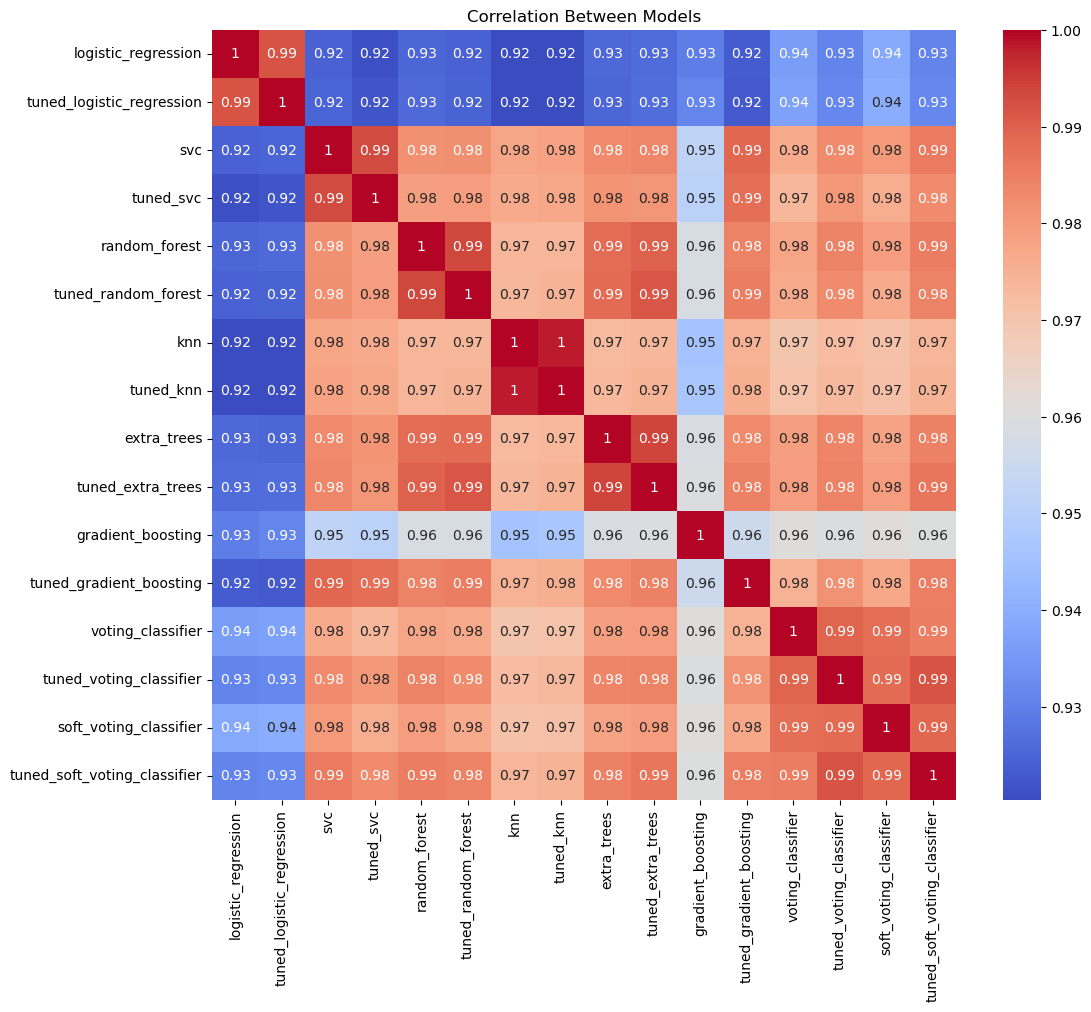

In [134]:
## visualize the correlation
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Between Models")
plt.show()

Observation:
* So we have 3 very strong (high importance) and highly correlated models which are `svc`, `tuned svc` and `tuned_gradient_boosting`.
* This tells us that most of the prediction by the blender is invfluenced by these 3 similarly predicting models.
* Which implies there is less diversity in our blender and this **might** not generalize well in production. 
* We can try training a different mix of highly important and non important features to see if it creates a model with better accuracy. We can add this as future enhancement


### Blended SVC

In [124]:
blended_svc = SVC(random_state=42, probability=True)

start_time = time.time()
blended_svc.fit(meta_X, meta_y)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f}s")

Training time: 1.92s


In [125]:
## predict on the test set
y_test_pred = blended_svc.predict(meta_X_test)

# Compute metrics
accuracy = accuracy_score(meta_y_test, y_test_pred)
weighted_f1 = f1_score(meta_y_test, y_test_pred, average='weighted')
# Compute per-class F1 scores
per_class_f1_scores = f1_score(meta_y_test, y_test_pred, average=None)
per_class_f1_dict = {f"Class_{i}": score
                     for i, score in enumerate(per_class_f1_scores)}

In [126]:
## print the metrics
print(f"Accuracy: {accuracy}")
print(f"Weighted F1: {weighted_f1}")
print("Per-class F1 scores: ", per_class_f1_dict)


Accuracy: 0.9763571428571428
Weighted F1: 0.9763746549068034
Per-class F1 scores:  {'Class_0': 0.9925373134328358, 'Class_1': 0.9890522364716922, 'Class_2': 0.9725036179450073, 'Class_3': 0.9698245614035088, 'Class_4': 0.9638370765131329, 'Class_5': 0.9774436090225563, 'Class_6': 0.987152034261242, 'Class_7': 0.9714854111405835, 'Class_8': 0.9613259668508287, 'Class_9': 0.9766123316796598}


Observations:
* In this case the the performance is at par with the default version of SVC. It could be because as we saw earlier `SVC` is a strong feature influencing the blender's predictions

In [127]:
## update the performance scores
performance_scores = performance_scores.dropna()
performance_scores = pd.concat([performance_scores,
    pd.DataFrame({"Model": "Blended SVC", "Accuracy": accuracy, "Weighted F1": weighted_f1, **per_class_f1_dict, "isEnsemble":True}, index=[0])], ignore_index=True)

In [129]:
## save performance scores 
performance_scores.to_csv(Path(data_root , 'ensemble_performance_scores.csv'), index=False)

## upload the performance scores to hugging face
path_or_fileobj = Path(data_root , 'ensemble_performance_scores.csv')
path_in_repo = path_or_fileobj.relative_to(data_root)
api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="dataset")

CommitInfo(commit_url='https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition/commit/26a1dd9198fa985bf6838f5cef6e880746c48e12', commit_message='Upload ensemble_performance_scores.csv with huggingface_hub', commit_description='', oid='26a1dd9198fa985bf6838f5cef6e880746c48e12', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition', endpoint='https://huggingface.co', repo_type='dataset', repo_id='gaurangdave/mnist_digits_recognition'), pr_revision=None, pr_num=None)

In [132]:
## save the model
saved_location = joblib.dump(blended_svc, model_dir + 'blended_svc_model.pkl')

## upload the model to hugging face
path_or_fileobj = Path(model_dir + 'blended_svc_model.pkl')
path_in_repo = path_or_fileobj.relative_to(model_root)
api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="model")


No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/gaurangdave/mnist_digits_recognition/commit/a387a32b4c66a96b28b934dde0d1738807403fd8', commit_message='Upload ensemble/blended_svc_model.pkl with huggingface_hub', commit_description='', oid='a387a32b4c66a96b28b934dde0d1738807403fd8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gaurangdave/mnist_digits_recognition', endpoint='https://huggingface.co', repo_type='model', repo_id='gaurangdave/mnist_digits_recognition'), pr_revision=None, pr_num=None)

* 🤦 I just realized, `sklearn` has `StackingClassifier` class to help create stacked blenders easily. For now I'll create manual blender to keep consistancy with previous models. We'll switch to `StackingClassifier` for hyper-tuned models.

### Blended Gradient Boosting

In [135]:
blended_gb = GradientBoostingClassifier(random_state=42)

start_time = time.time()
blended_gb.fit(meta_X, meta_y)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f}s")

Training time: 6.00s


In [136]:
## predict on the test set
y_test_pred = blended_gb.predict(meta_X_test)

# Compute metrics
accuracy = accuracy_score(meta_y_test, y_test_pred)
weighted_f1 = f1_score(meta_y_test, y_test_pred, average='weighted')
# Compute per-class F1 scores
per_class_f1_scores = f1_score(meta_y_test, y_test_pred, average=None)
per_class_f1_dict = {f"Class_{i}": score
                     for i, score in enumerate(per_class_f1_scores)}

In [137]:
## print the metrics
print(f"Accuracy: {accuracy}")
print(f"Weighted F1: {weighted_f1}")
print("Per-class F1 scores: ", per_class_f1_dict)


Accuracy: 0.9878571428571429
Weighted F1: 0.9878530969881978
Per-class F1 scores:  {'Class_0': 0.994413407821229, 'Class_1': 0.9943820224719101, 'Class_2': 0.9859154929577465, 'Class_3': 0.9853249475890985, 'Class_4': 0.9853395061728395, 'Class_5': 0.9862150452934226, 'Class_6': 0.9921484653818701, 'Class_7': 0.9863832613749585, 'Class_8': 0.9855609033691225, 'Class_9': 0.982010582010582}


* Observations
* Again the numbers here further confirm the tuned GB has a strong influence on the predictors, since these numbers are similar to stand alone tuned GB

In [138]:
## update the performance scores
performance_scores = performance_scores.dropna()
performance_scores = pd.concat([performance_scores,
    pd.DataFrame({"Model": "Blended GB", "Accuracy": accuracy, "Weighted F1": weighted_f1, **per_class_f1_dict, "isEnsemble":True}, index=[0])], ignore_index=True)

In [139]:
## save performance scores 
performance_scores.to_csv(Path(data_root , 'ensemble_performance_scores.csv'), index=False)

## upload the performance scores to hugging face
path_or_fileobj = Path(data_root , 'ensemble_performance_scores.csv')
path_in_repo = path_or_fileobj.relative_to(data_root)
api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="dataset")

CommitInfo(commit_url='https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition/commit/b6799350f301f761bcf59ade62493e8d2a6a491b', commit_message='Upload ensemble_performance_scores.csv with huggingface_hub', commit_description='', oid='b6799350f301f761bcf59ade62493e8d2a6a491b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition', endpoint='https://huggingface.co', repo_type='dataset', repo_id='gaurangdave/mnist_digits_recognition'), pr_revision=None, pr_num=None)

In [140]:
## save the model
saved_location = joblib.dump(blended_gb, model_dir + 'blended_gb.pkl')

## upload the model to hugging face
path_or_fileobj = Path(model_dir + 'blended_gb.pkl')
path_in_repo = path_or_fileobj.relative_to(model_root)
api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="model")


blended_gb.pkl:   0%|          | 0.00/1.79M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/gaurangdave/mnist_digits_recognition/commit/7f68b49593902c1c107ebd2c513354fba9b3e46f', commit_message='Upload ensemble/blended_gb.pkl with huggingface_hub', commit_description='', oid='7f68b49593902c1c107ebd2c513354fba9b3e46f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gaurangdave/mnist_digits_recognition', endpoint='https://huggingface.co', repo_type='model', repo_id='gaurangdave/mnist_digits_recognition'), pr_revision=None, pr_num=None)

## HyperParam Tuning

* In this section, we'll try to tune the parameters for 4 models that we experimented with earlier. 
* The main idea is to see if we can find a best model for our blender, that can out perform Tuned SVN. 

### Tuned Logistic Regression

In [ ]:
# for name, model in estimators.items():
#     print(name, type(model))

logistic_regression <class 'sklearn.pipeline.Pipeline'>
tuned_logistic_regression <class 'sklearn.pipeline.Pipeline'>
svc <class 'sklearn.pipeline.Pipeline'>
tuned_svc <class 'sklearn.pipeline.Pipeline'>
random_forest <class 'sklearn.pipeline.Pipeline'>
tuned_random_forest <class 'sklearn.pipeline.Pipeline'>
knn <class 'sklearn.pipeline.Pipeline'>
tuned_knn <class 'sklearn.pipeline.Pipeline'>
extra_trees <class 'sklearn.pipeline.Pipeline'>
tuned_extra_trees <class 'sklearn.pipeline.Pipeline'>
gradient_boosting <class 'sklearn.pipeline.Pipeline'>
tuned_gradient_boosting <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
voting_classifier <class 'sklearn.ensemble._voting.VotingClassifier'>
tuned_voting_classifier <class 'sklearn.ensemble._voting.VotingClassifier'>
soft_voting_classifier <class 'sklearn.ensemble._voting.VotingClassifier'>
tuned_soft_voting_classifier <class 'sklearn.ensemble._voting.VotingClassifier'>


In [27]:
# final_estimator = LogisticRegression(random_state=42, max_iter=10000)

# stacking_clf = StackingClassifier(
#     estimators=list(filtered_estimators.items()),
#     final_estimator=final_estimator,
#     passthrough=False,
#     n_jobs=-1
# )

# ## grid search for logistic regression hyperparameters
# param_grid = {
#     "final_estimator__C": [0.1, 1, 10],
#     "final_estimator__penalty": ["l1", "l2"],
#     "final_estimator__solver": ["liblinear", "newton-cg", "lbfgs", "sag", "saga"]    
# }

# blended_lr_grid_search = GridSearchCV(stacking_clf, param_grid, cv=3, verbose=1, n_jobs=-1)

# start_time = time.time()
# blended_lr_grid_search.fit(meta_X, meta_y)
# end_time = time.time()
# print(f"Training time: {end_time - start_time:.2f}s")


* So it seems hypertuning a `StackingClassifier` is a computationally expensive job. 
* `StackingClassifer` tends to refit the base estimators along with final estimators for each folds.  Which means if we have a lot of param grid options, it would take forever to find the right params. 
* Since we don't see any advantages of using `StackingClassifier` we'll go back to manual stacking for hyper tuning as well. 

In [34]:

# initialize LogisticRegression
blended_logistic_regression = LogisticRegression(random_state=42, max_iter=10000)

param_grid = {
    "solver": ["newton-cg", "sag", "saga", "lbfgs"],
    "penalty": ["l1", "l2"],
    "C": [0.1, 1, 10],
}

blended_lr_grid_search = GridSearchCV(blended_logistic_regression, param_grid, cv=3, verbose=1, n_jobs=-1, scoring="f1_weighted")


## fit the model
start_time = time.time()
blended_lr_grid_search.fit(meta_X, meta_y.values.ravel())
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f}s")

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/home/gaurangdave/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
27 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/home/gaurangdave/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/gaurangdave/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gaurangdave/anaconda3/envs/ml/lib/python

Training time: 157.01s


In [36]:
print(blended_lr_grid_search.best_score_)
print(blended_lr_grid_search.best_params_)

0.9780492067648928
{'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}


Observations:
* So there is a light improvement in the score but not significant. 
* Lets see how it performs against test data. 

In [37]:
## predict on the test set
y_test_pred = blended_lr_grid_search.best_estimator_.predict(meta_X_test)

# Compute metrics
accuracy = accuracy_score(meta_y_test, y_test_pred)
weighted_f1 = f1_score(meta_y_test, y_test_pred, average='weighted')
# Compute per-class F1 scores
per_class_f1_scores = f1_score(meta_y_test, y_test_pred, average=None)
per_class_f1_dict = {f"Class_{i}": score
                     for i, score in enumerate(per_class_f1_scores)}

In [38]:
## print the metrics
print(f"Accuracy: {accuracy}")
print(f"Weighted F1: {weighted_f1}")
print("Per-class F1 scores: ", per_class_f1_dict)

Accuracy: 0.9764285714285714
Weighted F1: 0.9764552276460317
Per-class F1 scores:  {'Class_0': 0.9925595238095238, 'Class_1': 0.9927967428750392, 'Class_2': 0.9738562091503268, 'Class_3': 0.969355406833392, 'Class_4': 0.9528916124090386, 'Class_5': 0.9675907848496681, 'Class_6': 0.9739803094233473, 'Class_7': 0.9776293823038398, 'Class_8': 0.9758454106280193, 'Class_9': 0.9837110481586402}


Observations:
* As expected no significant changes in the performance. 



In [39]:
## update the performance scores
performance_scores = performance_scores.dropna()
performance_scores = pd.concat([performance_scores,
    pd.DataFrame({"Model": "Tuned Blended Logistic Regression", "Accuracy": accuracy, "Weighted F1": weighted_f1, **per_class_f1_dict, "isEnsemble":True}, index=[0])], ignore_index=True)

In [40]:
## save performance scores
performance_scores.to_csv(Path(data_root , 'ensemble_performance_scores.csv'), index=False)

## upload the model to hugging face
path_or_fileobj = Path(data_root , 'ensemble_performance_scores.csv')
path_in_repo = path_or_fileobj.relative_to(data_root)
api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="dataset")

CommitInfo(commit_url='https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition/commit/33fb7ddd209121b2b46977086f4e84bd78cf190c', commit_message='Upload ensemble_performance_scores.csv with huggingface_hub', commit_description='', oid='33fb7ddd209121b2b46977086f4e84bd78cf190c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition', endpoint='https://huggingface.co', repo_type='dataset', repo_id='gaurangdave/mnist_digits_recognition'), pr_revision=None, pr_num=None)

In [41]:
## save the model
saved_location = joblib.dump(blended_lr_grid_search.best_estimator_, model_dir + 'tuned_blended_logistic_regression_model.pkl')

## upload the model to hugging face
path_or_fileobj = Path(model_dir + 'tuned_blended_logistic_regression_model.pkl')
path_in_repo = path_or_fileobj.relative_to(model_root)
api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="model")

tuned_blended_logistic_regression_model.pkl:   0%|          | 0.00/2.95k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/gaurangdave/mnist_digits_recognition/commit/5aab10d2b4f4d209164a065868b778d84060360d', commit_message='Upload ensemble/tuned_blended_logistic_regression_model.pkl with huggingface_hub', commit_description='', oid='5aab10d2b4f4d209164a065868b778d84060360d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gaurangdave/mnist_digits_recognition', endpoint='https://huggingface.co', repo_type='model', repo_id='gaurangdave/mnist_digits_recognition'), pr_revision=None, pr_num=None)

### Tuned Random Forest

In [43]:
# Define hyperparameter grid
param_grid = {
    "n_estimators": [50, 100, 200],  # Number of trees
    "max_depth": [None, 10, 20, 30],  # Depth of trees
    "min_samples_split": [2, 5, 10],  # Min samples to split a node
    "min_samples_leaf": [1, 2, 4],    # Min samples in a leaf
}

# Initialize Random Forest Classifier
tuned_blended_rfc = RandomForestClassifier(random_state=42)

# Create a pipeline

# Create a grid search object
blended_rfc_grid_search = GridSearchCV(tuned_blended_rfc, param_grid, cv=3, scoring="f1_weighted", n_jobs=-1, verbose=1)

start_time = time.time()
blended_rfc_grid_search.fit(meta_X, meta_y.values.ravel())
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f}s")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Training time: 12.63s


In [44]:
print(blended_rfc_grid_search.best_score_)
print(blended_rfc_grid_search.best_params_)



0.9890203607719855
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [45]:
## predict on the test set
y_test_pred = blended_rfc_grid_search.best_estimator_.predict(meta_X_test)

# Compute metrics
accuracy = accuracy_score(meta_y_test, y_test_pred)
weighted_f1 = f1_score(meta_y_test, y_test_pred, average='weighted')
# Compute per-class F1 scores
per_class_f1_scores = f1_score(meta_y_test, y_test_pred, average=None)
per_class_f1_dict = {f"Class_{i}": score
                        for i, score in enumerate(per_class_f1_scores)}

## print the metrics
print(f"Accuracy: {accuracy}")
print(f"Weighted F1: {weighted_f1}")
print("Per-class F1 scores: ", per_class_f1_dict)

Accuracy: 0.9869285714285714
Weighted F1: 0.9869275546869186
Per-class F1 scores:  {'Class_0': 0.9947800149142431, 'Class_1': 0.9928281883380106, 'Class_2': 0.9830386142186937, 'Class_3': 0.984938704028021, 'Class_4': 0.9853395061728395, 'Class_5': 0.9881703470031545, 'Class_6': 0.9932118613790639, 'Class_7': 0.9834437086092715, 'Class_8': 0.9837037037037037, 'Class_9': 0.9795630725863284}


Observations:
* This is closer to the best SVM classifier we trained earlier, but not better than that. 

In [46]:
## update the performance scores
performance_scores = performance_scores.dropna()
performance_scores = pd.concat([performance_scores,
    pd.DataFrame({"Model": "Tuned Blended Random Forest", "Accuracy": accuracy, "Weighted F1": weighted_f1, **per_class_f1_dict, "isEnsemble":True}, index=[0])], ignore_index=True)

In [47]:
## save performance scores
performance_scores.to_csv(Path(data_root , 'ensemble_performance_scores.csv'), index=False)

## upload the model to hugging face
path_or_fileobj = Path(data_root , 'ensemble_performance_scores.csv')
path_in_repo = path_or_fileobj.relative_to(data_root)
api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="dataset")

CommitInfo(commit_url='https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition/commit/96b0037db1d4a64178e85f1709e3caf7733083e9', commit_message='Upload ensemble_performance_scores.csv with huggingface_hub', commit_description='', oid='96b0037db1d4a64178e85f1709e3caf7733083e9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition', endpoint='https://huggingface.co', repo_type='dataset', repo_id='gaurangdave/mnist_digits_recognition'), pr_revision=None, pr_num=None)

In [49]:
## save the model
saved_location = joblib.dump(blended_rfc_grid_search.best_estimator_, model_dir + 'tuned_blended_random_forest_model.pkl')

## upload the model to hugging face
path_or_fileobj = Path(model_dir + 'tuned_blended_random_forest_model.pkl')
path_in_repo = path_or_fileobj.relative_to(model_root)
api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="model")


tuned_blended_random_forest_model.pkl:   0%|          | 0.00/2.25M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/gaurangdave/mnist_digits_recognition/commit/9ec50ecc8e63ed53d2b1da54495634a5b6e79972', commit_message='Upload ensemble/tuned_blended_random_forest_model.pkl with huggingface_hub', commit_description='', oid='9ec50ecc8e63ed53d2b1da54495634a5b6e79972', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gaurangdave/mnist_digits_recognition', endpoint='https://huggingface.co', repo_type='model', repo_id='gaurangdave/mnist_digits_recognition'), pr_revision=None, pr_num=None)

### Tuning SVC

In [58]:
## hypertuning svc
param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    # "degree": [2, 3, 4, 5],
    "gamma": ["scale", "auto"]
}

tuned_blended_svc = SVC(random_state=42, probability=True)

blended_svc_grid_search = RandomizedSearchCV(tuned_blended_svc, param_grid, cv=3, scoring="f1_weighted", n_jobs=-1, verbose=2, n_iter=10)

start_time = time.time()
blended_svc_grid_search.fit(meta_X, meta_y.values.ravel())
end_time = time.time()

print(f"Training time: {end_time - start_time:.2f}s")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   3.8s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   1.3s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   3.6s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   1.4s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   3.7s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   1.5s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   4.1s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   1.5s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   3.6s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   1.4s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   1.6s
[CV] END ...................C=10, gamma=auto, ke

[CV] END .......................C=1, gamma=auto, kernel=poly; total time=25.3min


In [59]:
print(blended_svc_grid_search.best_score_)
print(blended_svc_grid_search.best_params_)

0.9804531649295608
{'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}


In [60]:
## predict on the test set
y_test_pred = blended_svc_grid_search.best_estimator_.predict(meta_X_test)  

# Compute metrics
accuracy = accuracy_score(meta_y_test, y_test_pred)
weighted_f1 = f1_score(meta_y_test, y_test_pred, average='weighted')
# Compute per-class F1 scores
per_class_f1_scores = f1_score(meta_y_test, y_test_pred, average=None)
per_class_f1_dict = {f"Class_{i}": score
                        for i, score in enumerate(per_class_f1_scores)}

## print the metrics
print(f"Accuracy: {accuracy}")
print(f"Weighted F1: {weighted_f1}")
print("Per-class F1 scores: ", per_class_f1_dict)

Accuracy: 0.982
Weighted F1: 0.9820008576149563
Per-class F1 scores:  {'Class_0': 0.9932885906040269, 'Class_1': 0.9915651358950328, 'Class_2': 0.980561555075594, 'Class_3': 0.9740714786264891, 'Class_4': 0.9733898958735056, 'Class_5': 0.9849802371541502, 'Class_6': 0.9843860894251242, 'Class_7': 0.9783981389165836, 'Class_8': 0.976094152261861, 'Class_9': 0.9822443181818182}


In [61]:
## update the performance scores
performance_scores = performance_scores.dropna()
performance_scores = pd.concat([performance_scores,
    pd.DataFrame({"Model": "Tuned Blended SVC", "Accuracy": accuracy, "Weighted F1": weighted_f1, **per_class_f1_dict, "isEnsemble":True}, index=[0])], ignore_index=True)

## save performance scores
performance_scores.to_csv(Path(data_root , 'ensemble_performance_scores.csv'), index=False)

## upload the model to hugging face
path_or_fileobj = Path(data_root , 'ensemble_performance_scores.csv')
path_in_repo = path_or_fileobj.relative_to(data_root)
api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="dataset")

CommitInfo(commit_url='https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition/commit/c8236bd9e680d1ed3602cec17eb537fdc0e5d383', commit_message='Upload ensemble_performance_scores.csv with huggingface_hub', commit_description='', oid='c8236bd9e680d1ed3602cec17eb537fdc0e5d383', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition', endpoint='https://huggingface.co', repo_type='dataset', repo_id='gaurangdave/mnist_digits_recognition'), pr_revision=None, pr_num=None)

In [62]:
## save the model
saved_location = joblib.dump(blended_svc_grid_search.best_estimator_, model_dir + 'tuned_blended_svc_model.pkl')

## upload the model to hugging face
path_or_fileobj = Path(model_dir + 'tuned_blended_svc_model.pkl')
path_in_repo = path_or_fileobj.relative_to(model_root)
api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="model")


tuned_blended_svc_model.pkl:   0%|          | 0.00/285k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/gaurangdave/mnist_digits_recognition/commit/9d198f417345e35b10c1de99d02ee311f78fb114', commit_message='Upload ensemble/tuned_blended_svc_model.pkl with huggingface_hub', commit_description='', oid='9d198f417345e35b10c1de99d02ee311f78fb114', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gaurangdave/mnist_digits_recognition', endpoint='https://huggingface.co', repo_type='model', repo_id='gaurangdave/mnist_digits_recognition'), pr_revision=None, pr_num=None)